In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

import seaborn as sns
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [5]:
def plot_better(positions, diams, ax=None, lim=None):

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    # color_data = np.abs(soft_ffts[:,2:20]).sum(axis=-1)

    if lim is None:
        use = np.ones(len(positions), dtype=bool)
    else:
        use = (np.abs(positions[:,0]) < lim + 1) & (np.abs(positions[:,1]) < lim + 1)

    # create a list of circles with positions and radius
    color_data = np.zeros((len(positions), 3))
    cp = sns.color_palette("Paired")
    color_data[diams == 1.0] = cp[1]
    color_data[diams < 0.9] = cp[7]
    circles = [Circle((x[0], x[1]), radius=d/2.0, color=c, alpha=1.0) for x, d, c in zip(positions[use], diams[use], color_data[use])]

    # create a patch collection with circles and color data

    collection = PatchCollection(circles, match_original=True)

    # plot particles with color
    # fig, ax = plt.subplots()
    ax.add_collection(collection)
    ax.autoscale()

    # zoom in 5x
    if lim is None:
        zoom = 1.2
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
        ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)
    else:
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)

    # check if has colorbar
    # if ax.get_figure().get_axes()[-1] == ax:
    #     plt.colorbar(collection, label="Softness")


    ax.set_aspect('equal', adjustable='box')

    ax.axis('off')

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [03:04<00:00,  1.54s/it]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

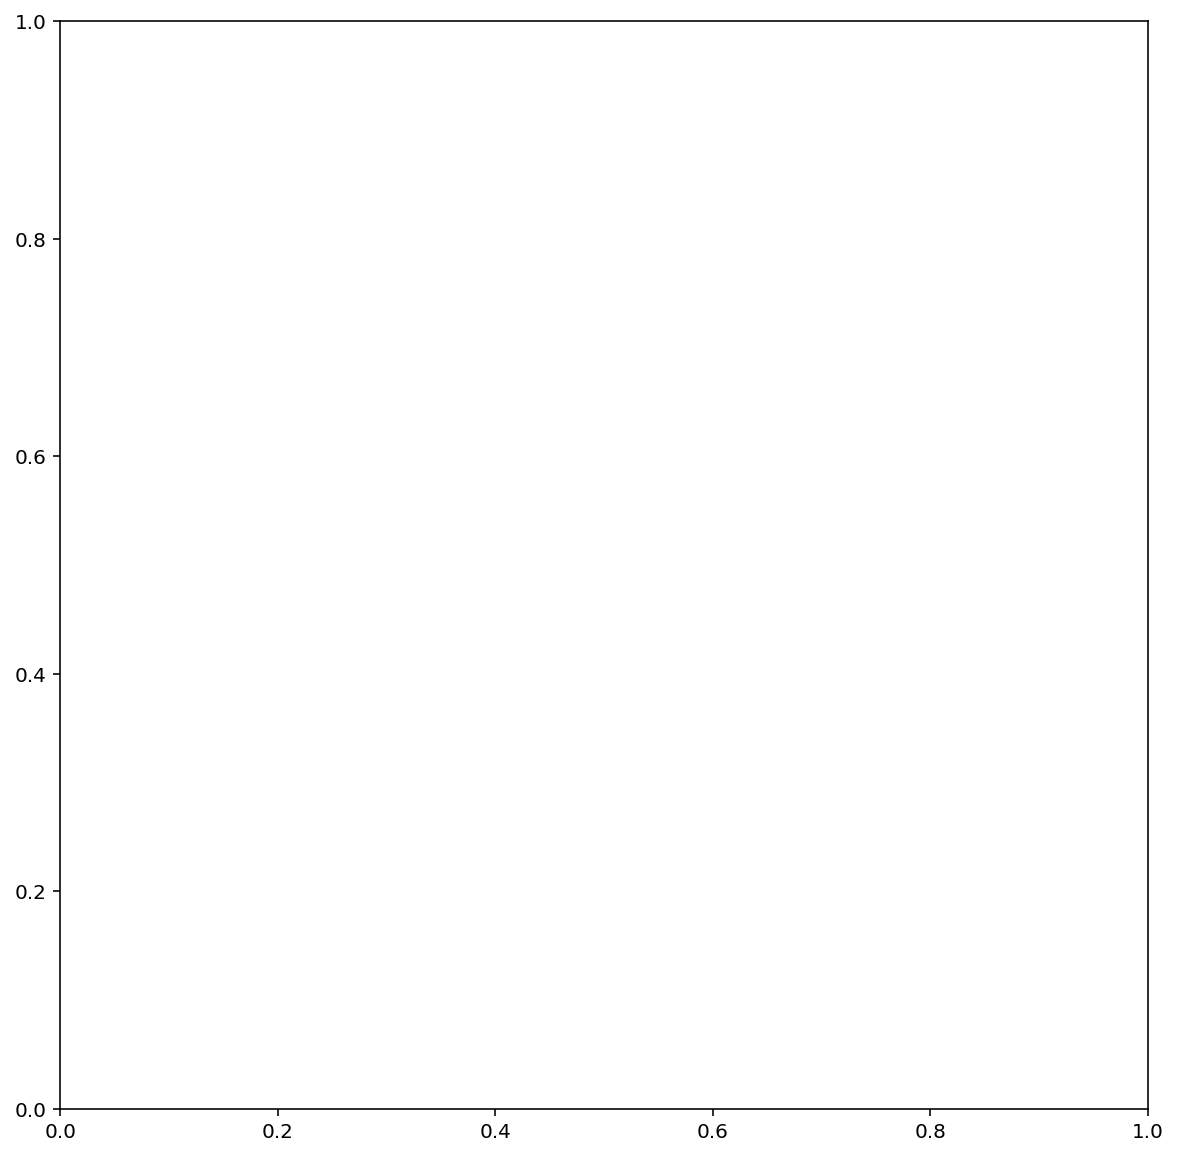

In [7]:
# get d2min distribution

# rev_quant = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue

    expers = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        # out_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"
        
        if float(period) != 1000.0 or float(max_shear) != 0.05:
            continue

        # if job.isfile(out_path):
        #     continue

        print(sp)

        output_file = f"videos/sim-movie-htl_max-shear-{max_shear}_id-{job.id}.mp4"

        # if os.path.exists(output_file):
        #     continue

        fig, ax = plt.subplots(figsize=(10,10))
        frame_path = job.fn("videos/sim-movie/")
        if os.path.exists(frame_path):
            shutil.rmtree(frame_path)
        os.makedirs(job.fn("videos/sim-movie/"), exist_ok=True)

        traj = gsd.hoomd.open(exper)

        frame_is = []
        frame_js = []
        ids = []
        msds = []
        ave_msds = []
        comp_start = lambda i: -1 + i*40
        i = 39
        snap = traj[i]
        tags = np.arange(len(snap.particles.position))

        init_pos = snap.particles.position
        images = np.zeros_like(init_pos, dtype=np.int32)
        last_pos = init_pos.copy()
        freud_box = freud.box.Box.from_box(snap.configuration.box)
        center = init_pos.mean(axis=0)

        diams = snap.particles.diameter

        for j in tqdm(range(i, i+120)):
            
            # frame_is.append(-1 + i*40)
            # frame_js.append(-1 + j*40)

            name = job.fn("videos/sim-movie/sim-movie-{:04d}.png".format(j))
            if os.path.exists(name):
                continue

            snap_later = traj[j]

            box = snap.configuration.box[:]
            box_later = snap_later.configuration.box[:]
            # ids.append(tags)

            # compute msd
            pos = snap_later.particles.position
            images -=  freud_box.get_images(pos - last_pos)
            last_pos = pos
            new_pos = freud_box.unwrap(pos, images)
            new_pos -= new_pos.mean(axis=0)
            new_pos = freud_box.wrap(new_pos)
            # msd = np.sum(np.square(new_pos - init_pos + center), axis=-1)
            # ave_msds.append(np.mean(msd))
            # msds.append(msd)

            plot_better(new_pos, diams, ax=ax, lim=40)
            plt.savefig(name, dpi=150)
            # clear axis
            ax.cla()
        #     break
        # break
        
        # dataset = pl.DataFrame({"frame_i": frame_is, "frame_j": frame_js, "id": ids, "msd": msds, "ave_msd": ave_msds})
        # dataset.write_parquet(job.fn(out_path), use_pyarrow=True)
        # msds = np.array(msds)

        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/sim-movie/sim-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
        break
    break